In [3]:
# ## Setup e Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
import gc

warnings.filterwarnings('ignore')

# Desabilitar GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

print("TensorFlow version:", tf.__version__)
print("GPU disponível:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.20.0
GPU disponível: False


2025-11-28 18:01:23.999172: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-28 18:01:23.999252: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-11-28 18:01:23.999266: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-11-28 18:01:23.999277: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-28 18:01:23.999287: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: maricarminate-MS-7E02
2025-11-28 18:01:23.999295: I external/local_xla/xla/stream_execu

In [4]:
# ## Diretório e Pastas

# Se estiver em notebooks/, suba para raiz
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"Mudando para: {os.getcwd()}")

# Criar pastas
Path('outputs/plots').mkdir(parents=True, exist_ok=True)
Path('outputs/models').mkdir(parents=True, exist_ok=True)
Path('outputs/reports').mkdir(parents=True, exist_ok=True)

print(f"Working directory: {os.getcwd()}")


Mudando para: /home/maricarminate/Projetos/anomaly-detector
Working directory: /home/maricarminate/Projetos/anomaly-detector


In [5]:
# ## Carregar Dados

print("\n" + "=" * 70)
print("DIA 5: LSTM AUTOENCODER PARA DETECÇÃO DE ANOMALIAS")
print("=" * 70)

train = pd.read_csv('data/processed/nyc_taxi_train.csv', parse_dates=['timestamp'])
test = pd.read_csv('data/processed/nyc_taxi_test.csv', parse_dates=['timestamp'])

# Reduzir tamanho pra LSTM (mais pesado que Dense)
train = train.head(2000)

print(f"\nDados carregados:")
print(f"  Treino: {len(train)} pontos")
print(f"  Teste: {len(test)} pontos")


DIA 5: LSTM AUTOENCODER PARA DETECÇÃO DE ANOMALIAS

Dados carregados:
  Treino: 2000 pontos
  Teste: 874 pontos


In [6]:
# ## Preparar Dados: Normalização e Sequências

print("\nNormalizando dados...")

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['value']])
test_scaled = scaler.transform(test[['value']])

print("✓ Dados normalizados (0-1)")

# Criar sequências
seq_len = 20  # Maior que Dia 4 pra LSTM aproveitar melhor

def create_sequences(data, seq_length):
    """Cria sequências para LSTM"""
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_train = create_sequences(train_scaled, seq_len)
X_test = create_sequences(test_scaled, seq_len)

print(f"\nSequências criadas:")
print(f"  X_train shape: {X_train.shape} (samples, timesteps, features)")
print(f"  X_test shape: {X_test.shape}")


Normalizando dados...
✓ Dados normalizados (0-1)

Sequências criadas:
  X_train shape: (1980, 20, 1) (samples, timesteps, features)
  X_test shape: (854, 20, 1)


In [7]:
# ## Construir LSTM Autoencoder

print("\n" + "=" * 70)
print("CONSTRUINDO LSTM AUTOENCODER")
print("=" * 70)

"""
Arquitetura:

ENCODER:
  Input (20, 1)
    ↓
  LSTM 32 units → captura features temporais
    ↓
  LSTM 16 units → comprime (latent space)

DECODER:
  RepeatVector(20) → expande de volta
    ↓
  LSTM 16 units → começa a reconstruir
    ↓
  LSTM 32 units → expande mais
    ↓
  TimeDistributed Dense 1 → output (20, 1)
"""

print("\nDefinindo arquitetura...")

# Input
inputs = layers.Input(shape=(seq_len, 1))

# ENCODER
encoder = layers.LSTM(32, activation='relu', return_sequences=True)(inputs)
encoder = layers.LSTM(16, activation='relu', return_sequences=False, name='latent')(encoder)

# DECODER
decoder = layers.RepeatVector(seq_len)(encoder)
decoder = layers.LSTM(16, activation='relu', return_sequences=True)(decoder)
decoder = layers.LSTM(32, activation='relu', return_sequences=True)(decoder)

# Output
outputs = layers.TimeDistributed(layers.Dense(1))(decoder)

# Compilar modelo
lstm_autoencoder = Model(inputs, outputs)
lstm_autoencoder.compile(optimizer=Adam(0.001), loss='mse')

print("\nArquitetura do modelo:")
lstm_autoencoder.summary()


CONSTRUINDO LSTM AUTOENCODER

Definindo arquitetura...

Arquitetura do modelo:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,905 (62.13 KB)

 Trainable params: 15,905 (62.13 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ## Treinar LSTM Autoencoder

print("\n" + "=" * 70)
print("TREINANDO LSTM AUTOENCODER")
print("=" * 70)
print("Isso pode levar 2-3 minutos...")

gc.collect()
tf.keras.backend.clear_session()

history = lstm_autoencoder.fit(
    X_train, X_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

print("\n✓ Treinamento concluído!")


TREINANDO LSTM AUTOENCODER
Isso pode levar 2-3 minutos...
Epoch 1/15
 1/56 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - loss: 0.3217

2025-11-28 18:01:27.698701: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.1666 - val_loss: 0.0863
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0741 - val_loss: 0.0625
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0516 - val_loss: 0.0418
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0379 - val_loss: 0.0367
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0323 - val_loss: 0.0275
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0225 - val_loss: 0.0164
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0160 - val_loss: 0.0131
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 9/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 10/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 11/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 12/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0077 - val_l

In [9]:
# ## Calcular Reconstruction Error

print("\nCalculando reconstruction error...")

train_pred = lstm_autoencoder.predict(X_train, verbose=0)
test_pred = lstm_autoencoder.predict(X_test, verbose=0)

train_mae = np.mean(np.abs(train_pred - X_train), axis=(1, 2))
test_mae = np.mean(np.abs(test_pred - X_test), axis=(1, 2))

threshold = np.percentile(train_mae, 95)
predictions = (test_mae > threshold).astype(int)

print(f"\nThreshold (95º percentil): {threshold:.6f}")
print(f"Anomalias detectadas: {predictions.sum()} ({100*predictions.sum()/len(predictions):.2f}%)")


Calculando reconstruction error...

Threshold (95º percentil): 0.086968
Anomalias detectadas: 31 (3.63%)


✓ Salvo: outputs/plots/05_training_history.png


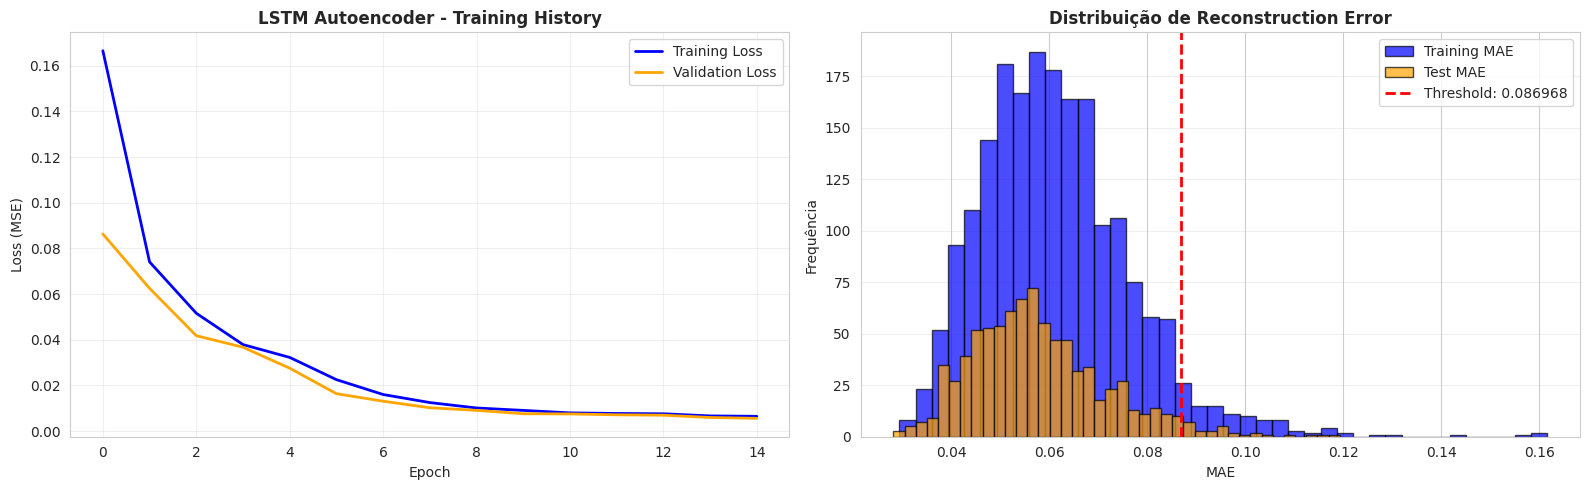

In [10]:
# ## Visualização 1: Training History

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training history
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0].set_title('LSTM Autoencoder - Training History', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribuição de erros
axes[1].hist(train_mae, bins=40, alpha=0.7, label='Training MAE', color='blue', edgecolor='black')
axes[1].hist(test_mae, bins=40, alpha=0.7, label='Test MAE', color='orange', edgecolor='black')
axes[1].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.6f}')
axes[1].set_title('Distribuição de Reconstruction Error', fontsize=12, fontweight='bold')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('Frequência')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/plots/05_training_history.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/05_training_history.png")
plt.show()



Gerando visualizações...
✓ Salvo: outputs/plots/05_anomalies_detected.png


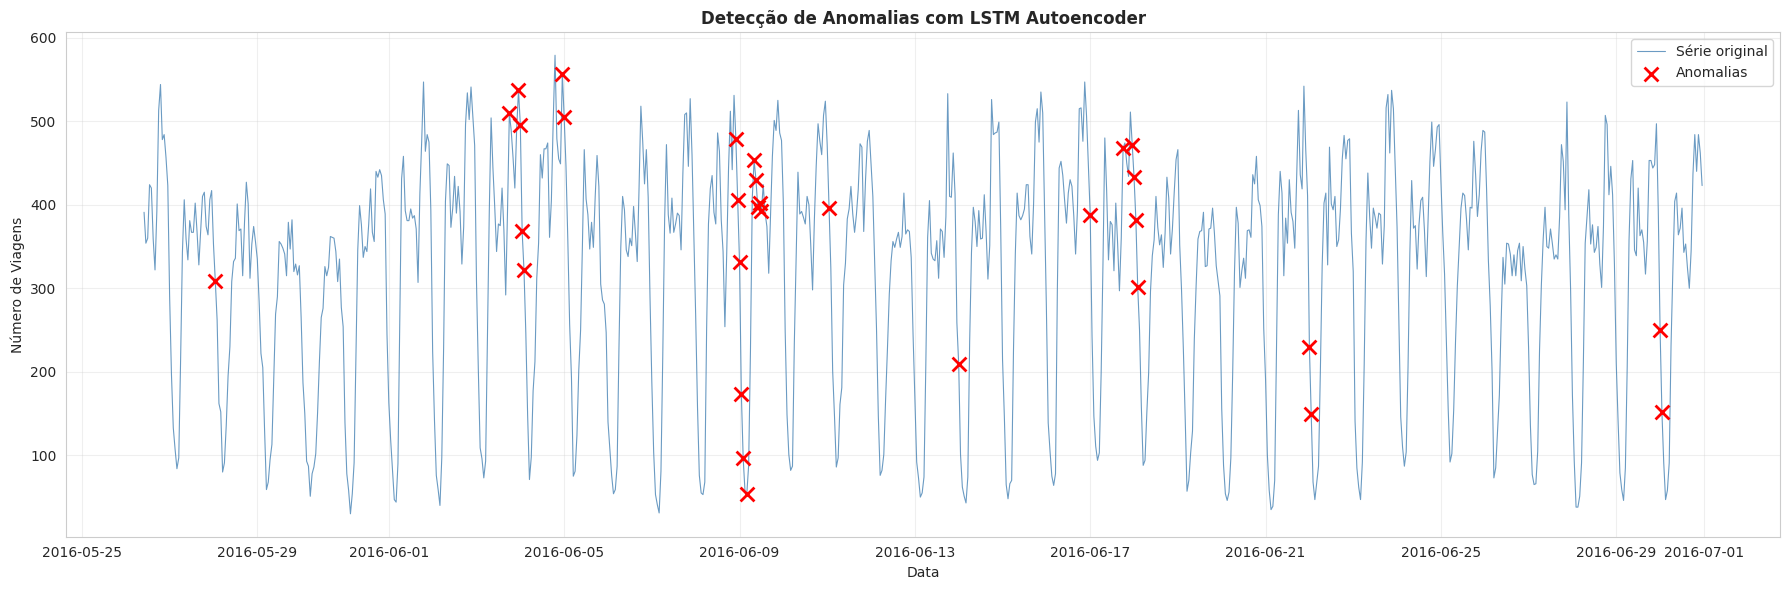

In [11]:
# ## Visualização 2: Série Temporal com Anomalias

print("\nGerando visualizações...")

test_aligned = test.iloc[seq_len:seq_len+len(test_mae)].reset_index(drop=True)
anomaly_idx = predictions == 1

fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(test_aligned['timestamp'], test_aligned['value'], 
        label='Série original', linewidth=0.8, color='steelblue', alpha=0.8)
ax.scatter(test_aligned[anomaly_idx]['timestamp'], test_aligned[anomaly_idx]['value'],
          color='red', s=100, marker='x', linewidth=2, label='Anomalias', zorder=5)
ax.set_title('Detecção de Anomalias com LSTM Autoencoder', fontsize=12, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Número de Viagens')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/05_anomalies_detected.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/05_anomalies_detected.png")
plt.show()

✓ Salvo: outputs/plots/05_error_timeline.png


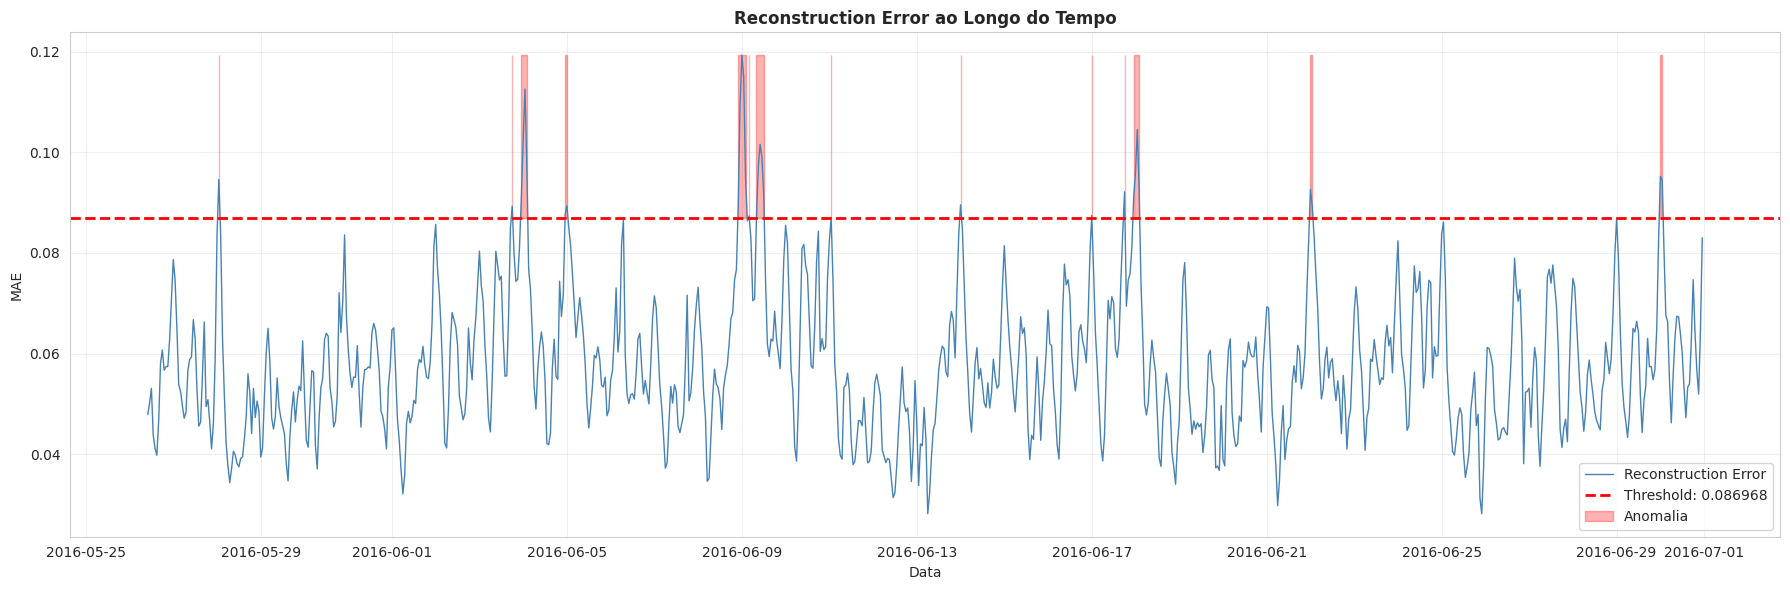

In [12]:
# ## Visualização 3: Reconstruction Error ao Longo do Tempo

fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(test_aligned['timestamp'], test_mae, linewidth=1, label='Reconstruction Error', color='steelblue')
ax.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.6f}')
ax.fill_between(test_aligned['timestamp'], threshold, test_mae.max(), 
                where=(test_mae > threshold), alpha=0.3, color='red', label='Anomalia')
ax.set_title('Reconstruction Error ao Longo do Tempo', fontsize=12, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('MAE')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/05_error_timeline.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/05_error_timeline.png")
plt.show()

✓ Salvo: outputs/plots/05_reconstruction_examples.png


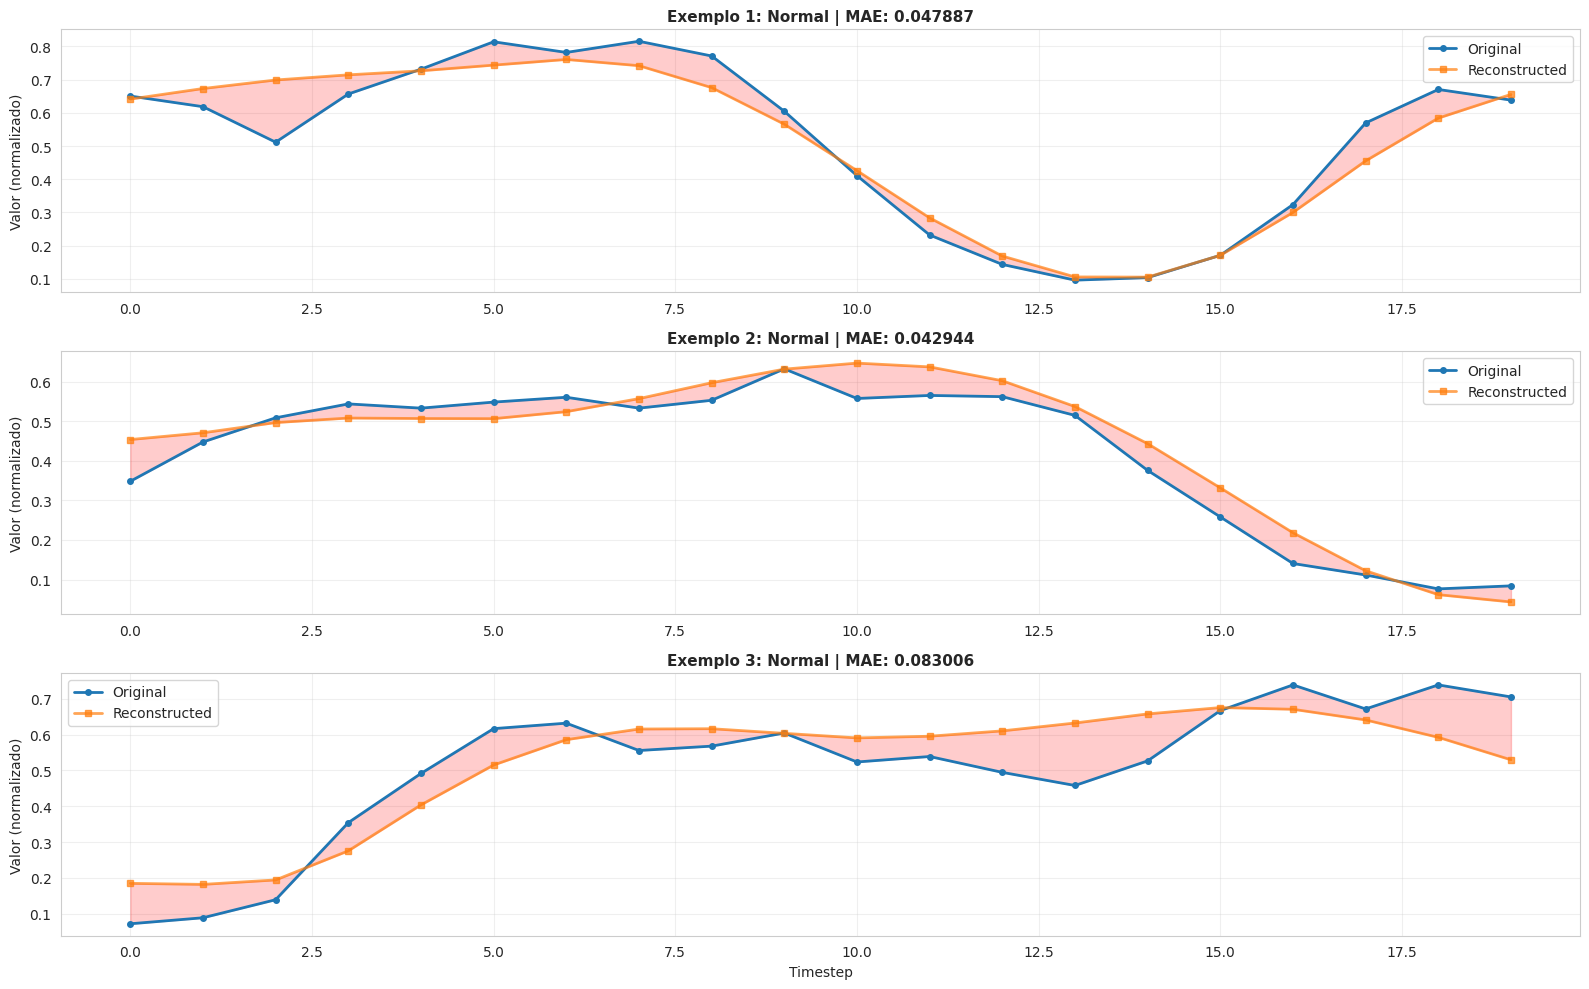

In [13]:
# ## Visualização 4: Exemplos de Reconstrução

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

for idx, i in enumerate([0, len(test_mae)//2, len(test_mae)-1]):
    original = X_test[i].flatten()
    reconstructed = test_pred[i].flatten()
    
    axes[idx].plot(original, label='Original', linewidth=2, marker='o', markersize=4)
    axes[idx].plot(reconstructed, label='Reconstructed', linewidth=2, marker='s', markersize=4, alpha=0.7)
    axes[idx].fill_between(range(len(original)), original, reconstructed, alpha=0.2, color='red')
    
    is_anomaly = "ANOMALIA" if predictions[i] == 1 else "Normal"
    axes[idx].set_title(f'Exemplo {idx+1}: {is_anomaly} | MAE: {test_mae[i]:.6f}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor (normalizado)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Timestep')
plt.tight_layout()
plt.savefig('outputs/plots/05_reconstruction_examples.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/05_reconstruction_examples.png")
plt.show()

In [14]:
# ## Salvar Modelo e Resultados

print("\nSalvando modelo e resultados...")

lstm_autoencoder.save('outputs/models/lstm_autoencoder_day5.h5')
print("✓ Modelo salvo: outputs/models/lstm_autoencoder_day5.h5")

results = test_aligned.copy()
results['reconstruction_error'] = test_mae
results['anomaly_predicted'] = predictions
results['threshold'] = threshold

results.to_csv('outputs/reports/day5_lstm_results.csv', index=False)
print("✓ Resultados salvos: outputs/reports/day5_lstm_results.csv")



Salvando modelo e resultados...
✓ Modelo salvo: outputs/models/lstm_autoencoder_day5.h5
✓ Resultados salvos: outputs/reports/day5_lstm_results.csv


In [15]:
# ## Resumo e Análise

print("\n" + "=" * 70)
print("RESUMO DO DIA 5")
print("=" * 70)

print(f"\n📊 LSTM AUTOENCODER:")
print(f"  Arquitetura: LSTM 32→16 (Encoder) + RepeatVector + LSTM 16→32 (Decoder)")
print(f"  Sequence length: {seq_len}")
print(f"  Latent dimension: 16")
print(f"  Epochs: 15")
print(f"  Training loss: {history.history['loss'][-1]:.6f}")
print(f"  Validation loss: {history.history['val_loss'][-1]:.6f}")

print(f"\n🎯 DETECÇÃO:")
print(f"  Threshold: {threshold:.6f}")
print(f"  Anomalias: {predictions.sum()} ({100*predictions.sum()/len(predictions):.2f}%)")
print(f"  MAE range: [{test_mae.min():.6f}, {test_mae.max():.6f}]")

print(f"\n✅ VANTAGENS DO LSTM:")
print(f"  • Captura dependências temporais (LSTM tem memória)")
print(f"  • Melhor que Dense pra séries cíclicas")
print(f"  • Menos sensível a ruído isolado")
print(f"  • Entende sequências, não apenas features")

print(f"\n⚠️ TRADE-OFFS:")
print(f"  • Mais lento de treinar que Dense")
print(f"  • Precisa de mais dados")
print(f"  • Mais hiperparâmetros pra ajustar")

print("\n" + "=" * 70)
print("✓ DIA 5 CONCLUÍDO!")
print("=" * 70)
print("\nPróximos passos:")
print("  - Comparar com resultados do Dia 4 (Dense Autoencoder)")
print("  - Ajustar seq_len ou epochs se necessário")
print("  - Dia 6: Ensemble de todos os modelos")


RESUMO DO DIA 5

📊 LSTM AUTOENCODER:
  Arquitetura: LSTM 32→16 (Encoder) + RepeatVector + LSTM 16→32 (Decoder)
  Sequence length: 20
  Latent dimension: 16
  Epochs: 15
  Training loss: 0.006467
  Validation loss: 0.005582

🎯 DETECÇÃO:
  Threshold: 0.086968
  Anomalias: 31 (3.63%)
  MAE range: [0.028154, 0.119255]

✅ VANTAGENS DO LSTM:
  • Captura dependências temporais (LSTM tem memória)
  • Melhor que Dense pra séries cíclicas
  • Menos sensível a ruído isolado
  • Entende sequências, não apenas features

⚠️ TRADE-OFFS:
  • Mais lento de treinar que Dense
  • Precisa de mais dados
  • Mais hiperparâmetros pra ajustar

✓ DIA 5 CONCLUÍDO!

Próximos passos:
  - Comparar com resultados do Dia 4 (Dense Autoencoder)
  - Ajustar seq_len ou epochs se necessário
  - Dia 6: Ensemble de todos os modelos
